In [1]:
import pandas as pd
import numpy as np
import os
import json
import yaml

In [48]:
columns = yaml.load(open(os.path.join(os.getcwd(), 'events.yaml')))


def get_event_name(dictionary: dict):
    """Gets value from dictionary for key `name` other returns None"""
    try:
        return dictionary.get('name', None)
    except AttributeError:
        return None

In [3]:
# shortcuts to path
matches = 'data/matches'
lineups = 'data/lineups'
events = 'data/events'
competition = 'competitions.json'

In [49]:
def get_event_name(dictionary: dict):
    """Gets value from dictionary for key `name` otherwise returns None"""
    try:
        return dictionary.get('name', None)
    except AttributeError:
        return None

In [5]:
def get_df(match_id: int, event_type: str, event_data: list) -> pd.DataFrame:
    events = [item for item in event_data if item['type']['name'] == event_type.title()]
    common_elements = [{key: event.get(key, None) for key in columns['common']} for event in events]
    event_objects = []
    for event in events:
        object_dict = {}
        for key in columns[event_type]:
            try:
                object_dict[key] = event[event_type].get(key, None)
            except KeyError:
                object_dict[key] = None
        event_objects.append(object_dict)
        
    df = pd.DataFrame([{**i, **j} for i, j in zip(common_elements, event_objects)])
    df['event_type'] = event_type
    df['match_id'] = match_id
    df = df[['match_id'] + ['event_type'] + columns['common'] + columns[event_type]]
        
    name_cols = [col for col in df.columns if col in columns['name_cols']]
    df[name_cols] = df[name_cols].applymap(get_event_name)
#     df[name_cols] = df[name_cols].applymap(lambda d: d.get('name', None))
        
    try:
        df[['start_location_x', 'start_location_y']] = df['location'].apply(pd.Series)
    except ValueError:
        pass
    df.drop(columns='location', inplace=True)
        
    if 'end_location' in df.columns:
        end_location_cols = ['end_location_x', 'end_location_y', 'end_location_z']
        try:
            df[end_location_cols] = df['end_location'].apply(pd.Series)
        except ValueError:
            df[['end_location_x', 'end_location_y']] = df['end_location'].apply(pd.Series)
        df.drop(columns='end_location', inplace=True)
    return df

In [6]:
def get_file(file_dir: str) -> list:
    dir_path = os.path.join(os.getcwd(), file_dir)
    file_path = os.listdir(dir_path)
    files = [os.path.join(dir_path, file) for file in file_path]
    return files

In [7]:
match_files = get_file(matches)
with open(match_files[-1]) as file:
    data = json.load(file)
wc_match_id = [str(match['match_id']) for match in data if match['competition']['competition_id'] == 43]
wc_event_files = [os.path.join(events, str(match_id)) for match_id in wc_match_id]

In [331]:
df = pd.DataFrame()
for event_file in wc_event_files:
    with open(event_file + '.json') as file: 
        data = json.load(file)
        df = df.append(get_df(int(event_file[-4:]), 'shot', data))
print('Load {} events in WC2018'.format(df.shape[0]))

Load 1706 events in WC2018


In [9]:
columns['name_cols']

['body_part',
 'play_pattern',
 'player',
 'position',
 'possession_team',
 'team',
 'technique',
 'type',
 'height',
 'recipient',
 'outcome',
 'card']

In [332]:
df.columns

Index(['match_id', 'event_type', 'id', 'index', 'period', 'timestamp',
       'minute', 'second', 'possession', 'possession_team', 'play_pattern',
       'off_camera', 'team', 'player', 'position', 'duration',
       'under_pressure', 'statsbomb_xg', 'key_pass_id', 'body_part', 'type',
       'outcome', 'technique', 'first_time', 'follows_dribble', 'redirect',
       'one_on_one', 'open_goal', 'deflected', 'start_location_x',
       'start_location_y', 'end_location_x', 'end_location_y',
       'end_location_z'],
      dtype='object')

In [333]:
# Exclude Goals from Penalty Shootout.
df['shot_distance'] = np.sqrt(((df['start_location_x'] - df['end_location_x']) ** 2) + ((df['start_location_y'] - df['end_location_y']) ** 2))
mean_xg = df[df['period'] < 5].groupby('team')['statsbomb_xg'].agg(['mean', 'count']).sort_values(by='count', ascending=False)
shot_outcome = pd.DataFrame(df[df['period'] < 5].groupby(['team', 'outcome'])['id'].count()).reset_index()

In [334]:
shot_outcome = shot_outcome.pivot(index='team', columns='outcome', values='id')
shot_outcome['match_played'] = df[['team', 'match_id']].groupby('team')['match_id'].nunique()

In [335]:
shot_outcome.fillna(0, inplace=True)

In [336]:
shot_outcome['total_shot'] = shot_outcome.iloc[:, -6:].apply(sum, axis=1)
shot_outcome['goal_conversion'] = shot_outcome['Goal']/shot_outcome['total_shot']

In [337]:
shot_outcome['shot_per_game'] = shot_outcome['total_shot']/shot_outcome['match_played']
shot_outcome['goal_per_game'] = shot_outcome['Goal']/shot_outcome['match_played']
shot_outcome['conversion_per_game'] = shot_outcome['goal_conversion']/(shot_outcome['match_played'])

In [338]:
# df.groupby('outcome')['shot_distance'].agg(['max', 'min', 'mean'])
df[(df['shot_distance'] > 31) & (df['outcome'] == 'Goal')].iloc[:, -6:]

,start_location_x,start_location_y,end_location_x,end_location_y,end_location_z,shot_distance
21,95.0,22.0,120.0,41.6,1.4,31.767279


In [339]:
shot_outcome.sort_values(by=['goal_conversion'], ascending=False)

outcome,Blocked,Goal,Off T,Post,Saved,Wayward,match_played,total_shot,goal_conversion,shot_per_game,goal_per_game,conversion_per_game
team,,,,,,,,,,,,
Russia,14.0,10.0,15.0,0.0,9.0,2.0,5,41.0,0.243902,8.200000,2.000000,0.048780
Colombia,13.0,6.0,12.0,0.0,6.0,4.0,4,32.0,0.187500,8.000000,1.500000,0.046875
Belgium,27.0,15.0,33.0,2.0,21.0,10.0,7,88.0,0.170455,12.571429,2.142857,0.024351
France,17.0,12.0,32.0,1.0,17.0,3.0,7,72.0,0.166667,10.285714,1.714286,0.023810
Japan,11.0,6.0,11.0,1.0,10.0,5.0,4,37.0,0.162162,9.250000,1.500000,0.040541
England,28.0,12.0,35.0,1.0,13.0,7.0,7,75.0,0.160000,10.714286,1.714286,0.022857
Argentina,23.0,6.0,14.0,1.0,11.0,3.0,4,39.0,0.153846,9.750000,1.500000,0.038462
Tunisia,8.0,5.0,10.0,0.0,7.0,8.0,3,33.0,0.151515,11.000000,1.666667,0.050505
Croatia,29.0,13.0,47.0,4.0,16.0,5.0,7,92.0,0.141304,13.142857,1.857143,0.020186


In [340]:
shot_outcome['progress'] = shot_outcome.match_played.map({3: 'group_stage', 4: 'round_16', 5: 'round_8', 7: 'finalists'})

In [341]:
shot_outcome.describe()

outcome,Blocked,Goal,Off T,Post,Saved,Wayward,match_played,total_shot,goal_conversion,shot_per_game,goal_per_game,conversion_per_game
count,32.000000,32.000000,32.000000,32.00000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,14.343750,4.906250,17.843750,0.71875,10.312500,3.968750,4.000000,41.750000,0.107947,10.212946,1.098289,0.027131
std,7.896955,3.813045,8.736683,0.92403,5.772222,2.494955,1.344043,19.488624,0.049517,2.210220,0.519533,0.010315
min,3.000000,1.000000,9.000000,0.00000,3.000000,0.000000,3.000000,22.000000,0.040000,7.333333,0.333333,0.013333
25%,8.000000,2.000000,12.000000,0.00000,7.000000,2.750000,3.000000,28.000000,0.066667,8.458333,0.666667,0.020487
50%,13.000000,3.000000,15.000000,0.50000,8.500000,3.500000,3.500000,34.000000,0.103006,9.775000,1.000000,0.023905
75%,20.000000,6.000000,21.000000,1.00000,13.250000,5.000000,4.250000,49.250000,0.143857,11.000000,1.500000,0.034189
max,30.000000,15.000000,47.000000,4.00000,31.000000,10.000000,7.000000,92.000000,0.243902,16.666667,2.142857,0.050505


In [30]:
shot_outcome.to_csv('shot_outcome_by_team.csv')

In [437]:
import matplotlib.pylab as plt
from matplotlib.patches import Ellipse
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 12]
plt.style.use('ggplot')

In [342]:
colour_dict = dict(zip(shot_outcome.progress.unique().tolist(), ['red', 'green', 'blue', 'orange']))

In [24]:
shot_outcome.index

Index(['Argentina', 'Australia', 'Belgium', 'Brazil', 'Colombia', 'Costa Rica',
       'Croatia', 'Denmark', 'Egypt', 'England', 'France', 'Germany',
       'Iceland', 'Iran', 'Japan', 'Mexico', 'Morocco', 'Nigeria', 'Panama',
       'Peru', 'Poland', 'Portugal', 'Russia', 'Saudi Arabia', 'Senegal',
       'Serbia', 'South Korea', 'Spain', 'Sweden', 'Switzerland', 'Tunisia',
       'Uruguay'],
      dtype='object', name='team')

In [34]:
from matplotlib.gridspec import GridSpec
def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        ax.tick_params(labelbottom=False, labelleft=False)

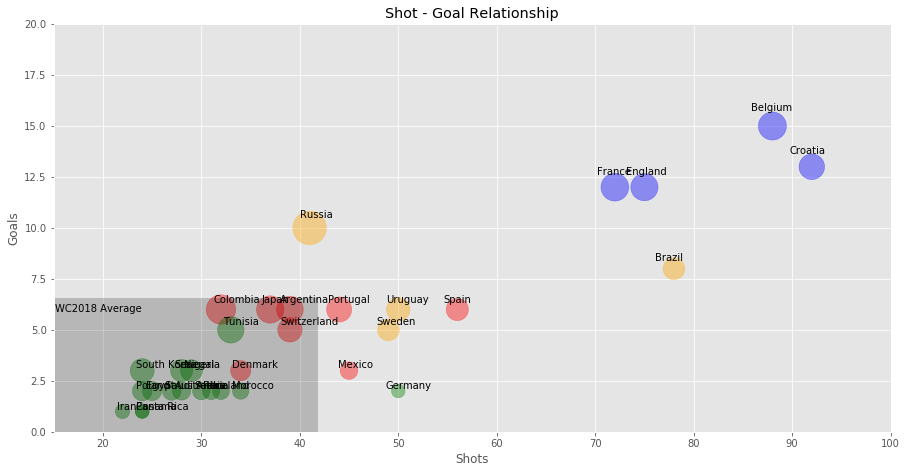

In [480]:
fig = plt.figure(figsize=(15, 7.5))
ax1 = fig.add_subplot(1,1,1)
ax1.scatter(shot_outcome.total_shot, shot_outcome.Goal,
            s=500 * shot_outcome.goal_conversion/shot_outcome.goal_conversion.mean(),
            c=shot_outcome.progress.apply(lambda x: colour_dict[x]),
           alpha=0.4)
ax1.axvspan(0,
            shot_outcome.total_shot.mean(),
            ymin=0,
            ymax=shot_outcome.Goal.mean()/shot_outcome.Goal.max(),
            alpha=0.2, color='black')
for i, txt in enumerate(shot_outcome.index):
    ax1.annotate(txt, (shot_outcome.total_shot[i] * 0.975, shot_outcome.Goal[i] * 1.05))

ax1.set_title('Shot - Goal Relationship')
ax1.set_xlabel('Shots')
ax1.set_ylabel('Goals')
ax1.set_xlim([15, 100])
ax1.set_ylim([0, 20])
ax1.annotate('WC2018 Average', xy=(15, 5), xytext=(15.1, shot_outcome.Goal.mean() * 1.2))
plt.savefig('pics/goal-shot-overall.png', format='png', bbox_inches='tight')
plt.show()

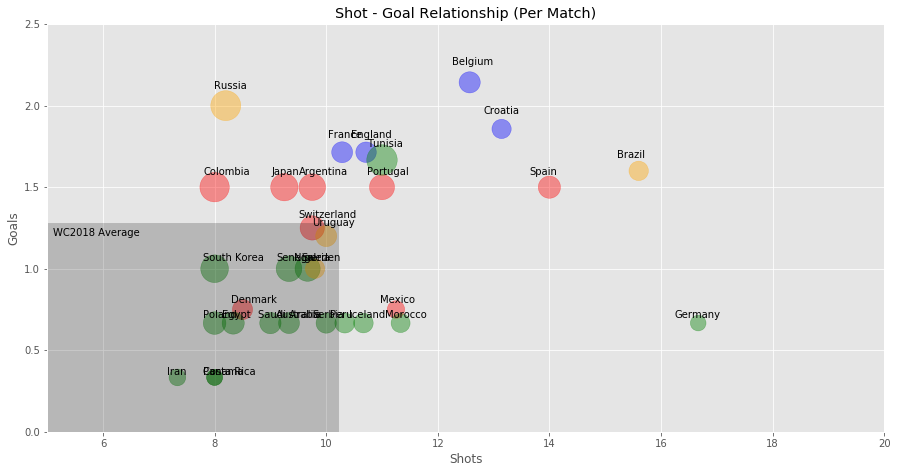

In [481]:
fig = plt.figure(figsize=(15, 7.5))
ax2 = fig.add_subplot(1,1,1)
ax2.scatter(shot_outcome.shot_per_game, shot_outcome.goal_per_game,
            s=500 * shot_outcome.conversion_per_game/shot_outcome.conversion_per_game.mean(),
            c=shot_outcome.progress.apply(lambda x: colour_dict[x]),
           alpha=0.4)
ax2.axvspan(0,
            shot_outcome.shot_per_game.mean(),
            ymin=0,
            ymax=shot_outcome.goal_per_game.mean()/shot_outcome.goal_per_game.max(),
            alpha=0.2, color='black')
for i, txt in enumerate(shot_outcome.index):
    ax2.annotate(txt, (shot_outcome.shot_per_game[i] * 0.975, shot_outcome.goal_per_game[i] * 1.05))

ax2.set_title('Shot - Goal Relationship (Per Match)')
ax2.set_xlabel('Shots')
ax2.set_ylabel('Goals')
ax2.set_xlim([5, 20])
ax2.set_ylim([0, 2.5])
ax2.annotate('WC2018 Average', xy=(5, 1), xytext=(5.1, shot_outcome.goal_per_game.mean() + 0.1))

plt.savefig('pics/goal-shot-permatch.png', format='png', bbox_inches='tight')
plt.show()

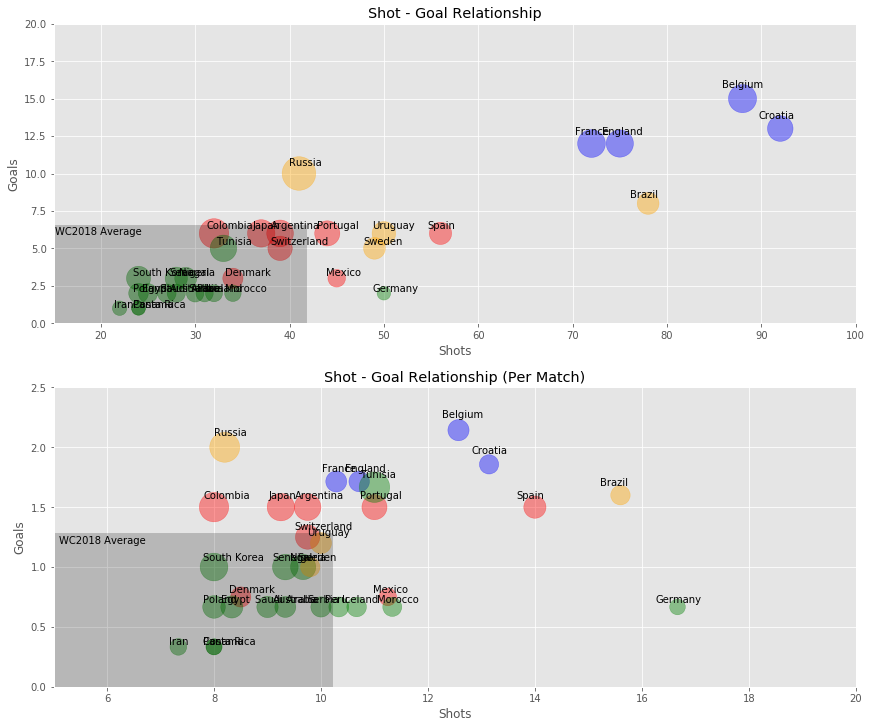

In [343]:
fig = plt.figure(constrained_layout=True)

gs = GridSpec(2, 2, figure=fig)
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])
# ax3 = fig.add_subplot(gs[1, 1])

ax1.scatter(shot_outcome.total_shot, shot_outcome.Goal,
            s=500 * shot_outcome.goal_conversion/shot_outcome.goal_conversion.mean(),
            c=shot_outcome.progress.apply(lambda x: colour_dict[x]),
           alpha=0.4)
ax1.axvspan(0,
            shot_outcome.total_shot.mean(),
            ymin=0,
            ymax=shot_outcome.Goal.mean()/shot_outcome.Goal.max(),
            alpha=0.2, color='black')
for i, txt in enumerate(shot_outcome.index):
    ax1.annotate(txt, (shot_outcome.total_shot[i] * 0.975, shot_outcome.Goal[i] * 1.05))

ax1.set_title('Shot - Goal Relationship')
ax1.set_xlabel('Shots')
ax1.set_ylabel('Goals')
ax1.set_xlim([15, 100])
ax1.set_ylim([0, 20])
ax1.annotate('WC2018 Average', xy=(15, 5), xytext=(15.1, shot_outcome.Goal.mean() * 1.2))
    
ax2.scatter(shot_outcome.shot_per_game, shot_outcome.goal_per_game,
            s=500 * shot_outcome.conversion_per_game/shot_outcome.conversion_per_game.mean(),
            c=shot_outcome.progress.apply(lambda x: colour_dict[x]),
           alpha=0.4)
ax2.axvspan(0,
            shot_outcome.shot_per_game.mean(),
            ymin=0,
            ymax=shot_outcome.goal_per_game.mean()/shot_outcome.goal_per_game.max(),
            alpha=0.2, color='black')
for i, txt in enumerate(shot_outcome.index):
    ax2.annotate(txt, (shot_outcome.shot_per_game[i] * 0.975, shot_outcome.goal_per_game[i] * 1.05))

ax2.set_title('Shot - Goal Relationship (Per Match)')
ax2.set_xlabel('Shots')
ax2.set_ylabel('Goals')
ax2.set_xlim([5, 20])
ax2.set_ylim([0, 2.5])
ax2.annotate('WC2018 Average', xy=(5, 1), xytext=(5.1, shot_outcome.goal_per_game.mean() + 0.1))

# fig.suptitle("WC2018 Shot Profile by Team")
# format_axes(fig)

fig.savefig('shot-profile.png', format='png')
plt.show()

In [671]:
shot_germany = df[(df['period'] < 5)][['team', 'shot_distance', 'start_location_x', 'start_location_y', 'end_location_x', 'end_location_y', 'outcome', 'play_pattern', 'type']].groupby('team').get_group('Germany')
shot_brazil = df[(df['period'] < 5)][['team', 'shot_distance', 'start_location_x', 'start_location_y', 'end_location_x', 'end_location_y', 'outcome', 'play_pattern', 'type']].groupby('team').get_group('Brazil')
shot_belgium = df[(df['period'] < 5)][['team', 'shot_distance', 'start_location_x', 'start_location_y', 'end_location_x', 'end_location_y', 'outcome', 'play_pattern', 'type']].groupby('team').get_group('Belgium')
shot_france = df[(df['period'] < 5)][['team', 'shot_distance', 'start_location_x', 'start_location_y', 'end_location_x', 'end_location_y', 'outcome', 'play_pattern', 'type']].groupby('team').get_group('France')

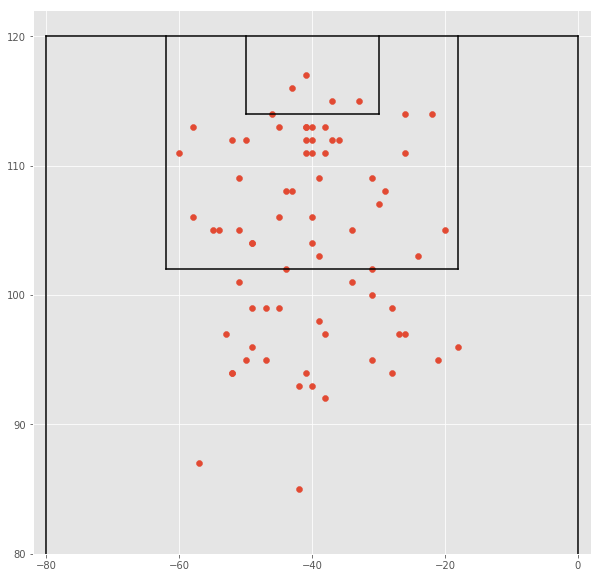

In [634]:
plt.figure(figsize=(10, 10))
plt.scatter(-(80 -shot_germany.start_location_y), shot_germany.start_location_x, marker='o')
# plt.scatter(shot_brazil.start_location_x, 80 -shot_brazil.start_location_y, marker='x')
# plt.scatter(shot_belgium.start_location_x, 80 - shot_belgium.start_location_y, marker='x')
# plt.scatter(shot_fracne.start_location_x, 80 -shot_fracne.start_location_y, marker='x')

plt.plot([-50, -50], [114, 120],color="black")
plt.plot([-30, -30], [114, 120],color="black")
plt.plot([-30,-50], [114, 114],color="black")

plt.plot([-62, -62], [102, 120],color="black")
plt.plot([-18, -18], [102, 120],color="black")
plt.plot([-62,-18], [102, 102],color="black")

plt.plot([-80, 0], [120, 120],color="black")
plt.plot([0, 0], [75, 120],color="black")
plt.plot([-80, -80], [75, 120],color="black")

plt.xlim([-82, 2])
plt.ylim([80, 122])
plt.yticks([80, 90, 100, 110, 120])
plt.xticks([0, -20, -40, -60, -80])
plt.show()

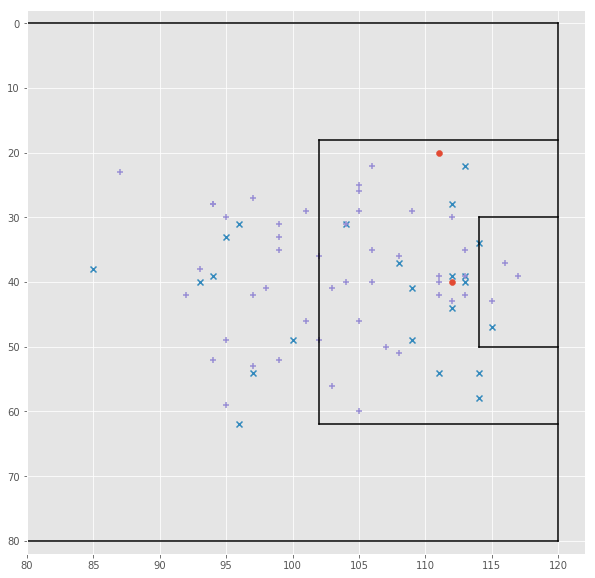

In [447]:
plt.figure(figsize=(10, 10))
plt.scatter(shot_germany[shot_germany.outcome == 'Goal'].start_location_x, shot_germany[shot_germany.outcome == 'Goal'].start_location_y, marker='o')
plt.scatter(shot_germany[shot_germany.outcome == 'Off T'].start_location_x, shot_germany[shot_germany.outcome == 'Off T'].start_location_y, marker='x')
plt.scatter(shot_germany[(shot_germany.outcome != 'Goal') & (shot_germany.outcome != 'Off T')].start_location_x,
            shot_germany[(shot_germany.outcome != 'Goal') & (shot_germany.outcome != 'Off T')].start_location_y, marker='+')

plt.plot([114, 120],[50, 50],color="black")
plt.plot([114, 120],[30, 30],color="black")
plt.plot([114, 114],[30,50],color="black")

plt.plot([102, 120],[62, 62],color="black")
plt.plot([102, 120],[18, 18],color="black")
plt.plot([102, 102],[18,62],color="black")

plt.plot([120, 120],[0, 80],color="black")
plt.plot([75, 120],[0, 0],color="black")
plt.plot([75, 120],[80, 80],color="black")

plt.xlim([80, 122])
plt.ylim([-2, 82])
plt.gca().invert_yaxis()
plt.show()

In [625]:
shot_brazil.outcome.unique()

array(['Saved', 'Blocked', 'Off T', 'Wayward', 'Goal', 'Post'],
      dtype=object)

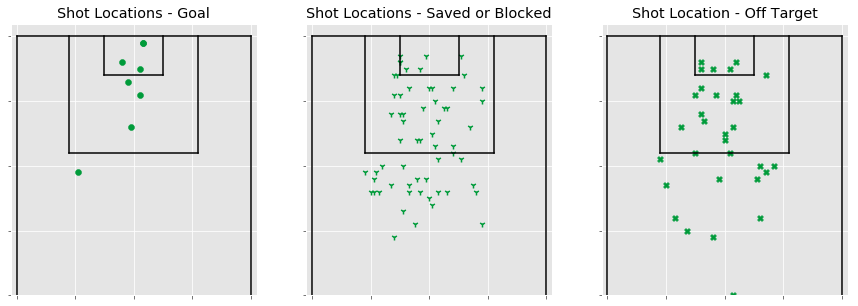

In [677]:
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(1, 3, 1)
ax1.scatter(-shot_brazil[(shot_brazil.outcome == 'Goal')].start_location_y,
            shot_brazil[(shot_brazil.outcome == 'Goal')].start_location_x,
            marker='o', color='#009b3a')
ax1.set_title('Shot Locations - Goal')
# ax2.scatter(shot_brazil[shot_brazil.outcome != 'Goal'].start_location_x,
#             shot_brazil[shot_brazil.outcome != 'Goal'].start_location_y,
#             marker='+', color='yellow')


plt.plot([-50, -50], [114, 120],color="black")
plt.plot([-30, -30], [114, 120],color="black")
plt.plot([-30,-50], [114, 114],color="black")

plt.plot([-62, -62], [102, 120],color="black")
plt.plot([-18, -18], [102, 120],color="black")
plt.plot([-62,-18], [102, 102],color="black")

plt.plot([-80, 0], [120, 120],color="black")
plt.plot([0, 0], [75, 120],color="black")
plt.plot([-80, -80], [75, 120],color="black")

plt.xlim([-82, 2])
plt.ylim([80, 122])
plt.yticks([80, 90, 100, 110, 120])
plt.xticks([0, -20, -40, -60, -80])
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax1.get_yticklabels(), visible=False)
plt.gca().invert_xaxis()

ax2 = fig.add_subplot(1, 3, 2)
ax2.scatter(-shot_brazil[(shot_brazil.outcome == 'Blocked') | (shot_brazil.outcome == 'Saved')].start_location_y,
            shot_brazil[(shot_brazil.outcome == 'Blocked') | (shot_brazil.outcome == 'Saved')].start_location_x,
            marker='1', color='#009b3a')
ax2.set_title('Shot Locations - Saved or Blocked')

plt.plot([-50, -50], [114, 120],color="black")
plt.plot([-30, -30], [114, 120],color="black")
plt.plot([-30,-50], [114, 114],color="black")

plt.plot([-62, -62], [102, 120],color="black")
plt.plot([-18, -18], [102, 120],color="black")
plt.plot([-62,-18], [102, 102],color="black")

plt.plot([-80, 0], [120, 120],color="black")
plt.plot([0, 0], [75, 120],color="black")
plt.plot([-80, -80], [75, 120],color="black")

plt.xlim([-82, 2])
plt.ylim([80, 122])
plt.yticks([80, 90, 100, 110, 120])
plt.xticks([0, -20, -40, -60, -80])
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.gca().invert_xaxis()

ax3 = fig.add_subplot(1, 3, 3)
ax3.scatter(-shot_brazil[(shot_brazil.outcome == 'Off T') | (shot_brazil.outcome == 'Wayward')].start_location_y,
            shot_brazil[(shot_brazil.outcome == 'Off T') | (shot_brazil.outcome == 'Wayward')].start_location_x,
            marker='X', color='#009b3a')

ax3.set_title('Shot Location - Off Target')

plt.plot([-50, -50], [114, 120],color="black")
plt.plot([-30, -30], [114, 120],color="black")
plt.plot([-30,-50], [114, 114],color="black")

plt.plot([-62, -62], [102, 120],color="black")
plt.plot([-18, -18], [102, 120],color="black")
plt.plot([-62,-18], [102, 102],color="black")

plt.plot([-80, 0], [120, 120],color="black")
plt.plot([0, 0], [75, 120],color="black")
plt.plot([-80, -80], [75, 120],color="black")

plt.xlim([-82, 2])
plt.ylim([80, 122])
plt.yticks([80, 90, 100, 110, 120])
plt.xticks([0, -20, -40, -60, -80])
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)
plt.gca().invert_xaxis()

plt.savefig('pics/shot-map-brazil.png', format='png', bbox_inches='tight')
plt.show()

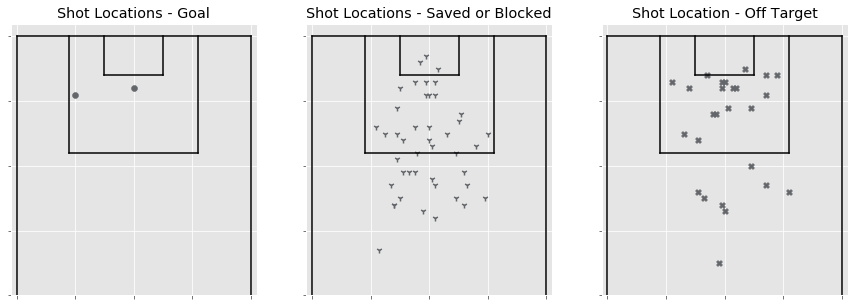

In [678]:
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(1, 3, 1)
ax1.scatter(-shot_germany[(shot_germany.outcome == 'Goal')].start_location_y,
            shot_germany[(shot_germany.outcome == 'Goal')].start_location_x,
            marker='o', color='#63666A')
ax1.set_title('Shot Locations - Goal')
# ax2.scatter(shot_brazil[shot_brazil.outcome != 'Goal'].start_location_x,
#             shot_brazil[shot_brazil.outcome != 'Goal'].start_location_y,
#             marker='+', color='yellow')


plt.plot([-50, -50], [114, 120],color="black")
plt.plot([-30, -30], [114, 120],color="black")
plt.plot([-30,-50], [114, 114],color="black")

plt.plot([-62, -62], [102, 120],color="black")
plt.plot([-18, -18], [102, 120],color="black")
plt.plot([-62,-18], [102, 102],color="black")

plt.plot([-80, 0], [120, 120],color="black")
plt.plot([0, 0], [75, 120],color="black")
plt.plot([-80, -80], [75, 120],color="black")

plt.xlim([-82, 2])
plt.ylim([80, 122])
plt.yticks([80, 90, 100, 110, 120])
plt.xticks([0, -20, -40, -60, -80])
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax1.get_yticklabels(), visible=False)
plt.gca().invert_xaxis()

ax2 = fig.add_subplot(1, 3, 2)
ax2.scatter(-shot_germany[(shot_germany.outcome == 'Blocked') | (shot_germany.outcome == 'Saved')].start_location_y,
            shot_germany[(shot_germany.outcome == 'Blocked') | (shot_germany.outcome == 'Saved')].start_location_x,
            marker='1', color='#63666A')
ax2.set_title('Shot Locations - Saved or Blocked')

plt.plot([-50, -50], [114, 120],color="black")
plt.plot([-30, -30], [114, 120],color="black")
plt.plot([-30,-50], [114, 114],color="black")

plt.plot([-62, -62], [102, 120],color="black")
plt.plot([-18, -18], [102, 120],color="black")
plt.plot([-62,-18], [102, 102],color="black")

plt.plot([-80, 0], [120, 120],color="black")
plt.plot([0, 0], [75, 120],color="black")
plt.plot([-80, -80], [75, 120],color="black")

plt.xlim([-82, 2])
plt.ylim([80, 122])
plt.yticks([80, 90, 100, 110, 120])
plt.xticks([0, -20, -40, -60, -80])
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.gca().invert_xaxis()

ax3 = fig.add_subplot(1, 3, 3)
ax3.scatter(-shot_germany[(shot_germany.outcome == 'Off T') | (shot_germany.outcome == 'Wayward')].start_location_y,
            shot_germany[(shot_germany.outcome == 'Off T') | (shot_germany.outcome == 'Wayward')].start_location_x,
            marker='X', color='#63666A')

ax3.set_title('Shot Location - Off Target')

plt.plot([-50, -50], [114, 120],color="black")
plt.plot([-30, -30], [114, 120],color="black")
plt.plot([-30,-50], [114, 114],color="black")

plt.plot([-62, -62], [102, 120],color="black")
plt.plot([-18, -18], [102, 120],color="black")
plt.plot([-62,-18], [102, 102],color="black")

plt.plot([-80, 0], [120, 120],color="black")
plt.plot([0, 0], [75, 120],color="black")
plt.plot([-80, -80], [75, 120],color="black")

plt.xlim([-82, 2])
plt.ylim([80, 122])
plt.yticks([80, 90, 100, 110, 120])
plt.xticks([0, -20, -40, -60, -80])
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)
plt.gca().invert_xaxis()

plt.savefig('pics/shot-map-germany.png', format='png', bbox_inches='tight')
plt.show()

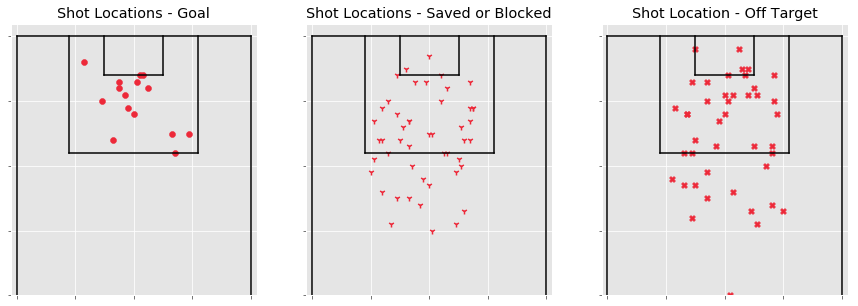

In [679]:
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(1, 3, 1)
ax1.scatter(-shot_belgium[(shot_belgium.outcome == 'Goal')].start_location_y,
            shot_belgium[(shot_belgium.outcome == 'Goal')].start_location_x,
            marker='o', color='#ED2939')
ax1.set_title('Shot Locations - Goal')
# ax2.scatter(shot_brazil[shot_brazil.outcome != 'Goal'].start_location_x,
#             shot_brazil[shot_brazil.outcome != 'Goal'].start_location_y,
#             marker='+', color='yellow')


plt.plot([-50, -50], [114, 120],color="black")
plt.plot([-30, -30], [114, 120],color="black")
plt.plot([-30,-50], [114, 114],color="black")

plt.plot([-62, -62], [102, 120],color="black")
plt.plot([-18, -18], [102, 120],color="black")
plt.plot([-62,-18], [102, 102],color="black")

plt.plot([-80, 0], [120, 120],color="black")
plt.plot([0, 0], [75, 120],color="black")
plt.plot([-80, -80], [75, 120],color="black")

plt.xlim([-82, 2])
plt.ylim([80, 122])
plt.yticks([80, 90, 100, 110, 120])
plt.xticks([0, -20, -40, -60, -80])
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax1.get_yticklabels(), visible=False)
plt.gca().invert_xaxis()

ax2 = fig.add_subplot(1, 3, 2)
ax2.scatter(-shot_belgium[(shot_belgium.outcome == 'Blocked') | (shot_belgium.outcome == 'Saved')].start_location_y,
            shot_belgium[(shot_belgium.outcome == 'Blocked') | (shot_belgium.outcome == 'Saved')].start_location_x,
            marker='1', color='#ED2939')
ax2.set_title('Shot Locations - Saved or Blocked')

plt.plot([-50, -50], [114, 120],color="black")
plt.plot([-30, -30], [114, 120],color="black")
plt.plot([-30,-50], [114, 114],color="black")

plt.plot([-62, -62], [102, 120],color="black")
plt.plot([-18, -18], [102, 120],color="black")
plt.plot([-62,-18], [102, 102],color="black")

plt.plot([-80, 0], [120, 120],color="black")
plt.plot([0, 0], [75, 120],color="black")
plt.plot([-80, -80], [75, 120],color="black")

plt.xlim([-82, 2])
plt.ylim([80, 122])
plt.yticks([80, 90, 100, 110, 120])
plt.xticks([0, -20, -40, -60, -80])
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.gca().invert_xaxis()

ax3 = fig.add_subplot(1, 3, 3)
ax3.scatter(-shot_belgium[(shot_belgium.outcome == 'Off T') | (shot_belgium.outcome == 'Wayward')].start_location_y,
            shot_belgium[(shot_belgium.outcome == 'Off T') | (shot_belgium.outcome == 'Wayward')].start_location_x,
            marker='X', color='#ED2939')

ax3.set_title('Shot Location - Off Target')

plt.plot([-50, -50], [114, 120],color="black")
plt.plot([-30, -30], [114, 120],color="black")
plt.plot([-30,-50], [114, 114],color="black")

plt.plot([-62, -62], [102, 120],color="black")
plt.plot([-18, -18], [102, 120],color="black")
plt.plot([-62,-18], [102, 102],color="black")

plt.plot([-80, 0], [120, 120],color="black")
plt.plot([0, 0], [75, 120],color="black")
plt.plot([-80, -80], [75, 120],color="black")

plt.xlim([-82, 2])
plt.ylim([80, 122])
plt.yticks([80, 90, 100, 110, 120])
plt.xticks([0, -20, -40, -60, -80])
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)
plt.gca().invert_xaxis()

plt.savefig('pics/shot-map-belgium.png', format='png', bbox_inches='tight')
plt.show()

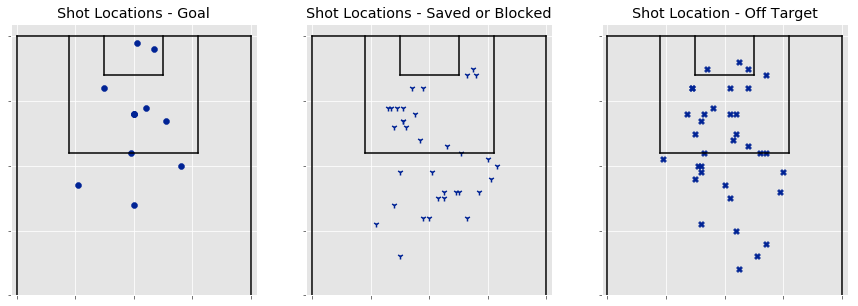

In [680]:
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(1, 3, 1)
ax1.scatter(-shot_france[(shot_france.outcome == 'Goal')].start_location_y,
            shot_france[(shot_france.outcome == 'Goal')].start_location_x,
            marker='o', color='#002395')
ax1.set_title('Shot Locations - Goal')
# ax2.scatter(shot_brazil[shot_brazil.outcome != 'Goal'].start_location_x,
#             shot_brazil[shot_brazil.outcome != 'Goal'].start_location_y,
#             marker='+', color='yellow')


plt.plot([-50, -50], [114, 120],color="black")
plt.plot([-30, -30], [114, 120],color="black")
plt.plot([-30,-50], [114, 114],color="black")

plt.plot([-62, -62], [102, 120],color="black")
plt.plot([-18, -18], [102, 120],color="black")
plt.plot([-62,-18], [102, 102],color="black")

plt.plot([-80, 0], [120, 120],color="black")
plt.plot([0, 0], [75, 120],color="black")
plt.plot([-80, -80], [75, 120],color="black")

plt.xlim([-82, 2])
plt.ylim([80, 122])
plt.yticks([80, 90, 100, 110, 120])
plt.xticks([0, -20, -40, -60, -80])
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax1.get_yticklabels(), visible=False)
plt.gca().invert_xaxis()

ax2 = fig.add_subplot(1, 3, 2)
ax2.scatter(-shot_france[(shot_france.outcome == 'Blocked') | (shot_france.outcome == 'Saved')].start_location_y,
            shot_france[(shot_france.outcome == 'Blocked') | (shot_france.outcome == 'Saved')].start_location_x,
            marker='1', color='#002395')
ax2.set_title('Shot Locations - Saved or Blocked')

plt.plot([-50, -50], [114, 120],color="black")
plt.plot([-30, -30], [114, 120],color="black")
plt.plot([-30,-50], [114, 114],color="black")

plt.plot([-62, -62], [102, 120],color="black")
plt.plot([-18, -18], [102, 120],color="black")
plt.plot([-62,-18], [102, 102],color="black")

plt.plot([-80, 0], [120, 120],color="black")
plt.plot([0, 0], [75, 120],color="black")
plt.plot([-80, -80], [75, 120],color="black")

plt.xlim([-82, 2])
plt.ylim([80, 122])
plt.yticks([80, 90, 100, 110, 120])
plt.xticks([0, -20, -40, -60, -80])
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.gca().invert_xaxis()

ax3 = fig.add_subplot(1, 3, 3)
ax3.scatter(-shot_france[(shot_france.outcome == 'Off T') | (shot_france.outcome == 'Wayward')].start_location_y,
            shot_france[(shot_france.outcome == 'Off T') | (shot_france.outcome == 'Wayward')].start_location_x,
            marker='X', color='#002395')

ax3.set_title('Shot Location - Off Target')

plt.plot([-50, -50], [114, 120],color="black")
plt.plot([-30, -30], [114, 120],color="black")
plt.plot([-30,-50], [114, 114],color="black")

plt.plot([-62, -62], [102, 120],color="black")
plt.plot([-18, -18], [102, 120],color="black")
plt.plot([-62,-18], [102, 102],color="black")

plt.plot([-80, 0], [120, 120],color="black")
plt.plot([0, 0], [75, 120],color="black")
plt.plot([-80, -80], [75, 120],color="black")

plt.xlim([-82, 2])
plt.ylim([80, 122])
plt.yticks([80, 90, 100, 110, 120])
plt.xticks([0, -20, -40, -60, -80])
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)
plt.gca().invert_xaxis()

plt.savefig('pics/shot-map-france.png', format='png', bbox_inches='tight')
plt.show()

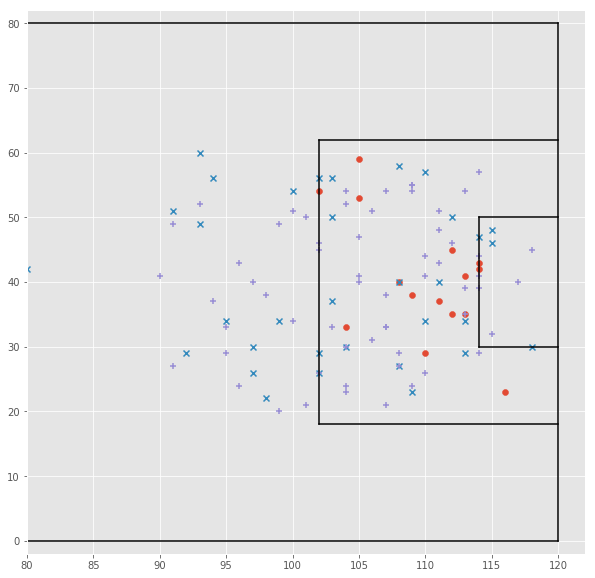

In [449]:
plt.figure(figsize=(10, 10))
plt.scatter(shot_belgium[shot_belgium.outcome == 'Goal'].start_location_x, shot_belgium[shot_belgium.outcome == 'Goal'].start_location_y, marker='o')
plt.scatter(shot_belgium[shot_belgium.outcome == 'Off T'].start_location_x, shot_belgium[shot_belgium.outcome == 'Off T'].start_location_y, marker='x')
plt.scatter(shot_belgium[(shot_belgium.outcome != 'Goal') & (shot_belgium.outcome != 'Off T')].start_location_x,
            shot_belgium[(shot_belgium.outcome != 'Goal') & (shot_belgium.outcome != 'Off T')].start_location_y, marker='+')

plt.plot([114, 120],[50, 50],color="black")
plt.plot([114, 120],[30, 30],color="black")
plt.plot([114, 114],[30,50],color="black")

plt.plot([102, 120],[62, 62],color="black")
plt.plot([102, 120],[18, 18],color="black")
plt.plot([102, 102],[18,62],color="black")

plt.plot([120, 120],[0, 80],color="black")
plt.plot([75, 120],[0, 0],color="black")
plt.plot([75, 120],[80, 80],color="black")

plt.xlim([80, 122])
plt.ylim([-2, 82])
plt.show()

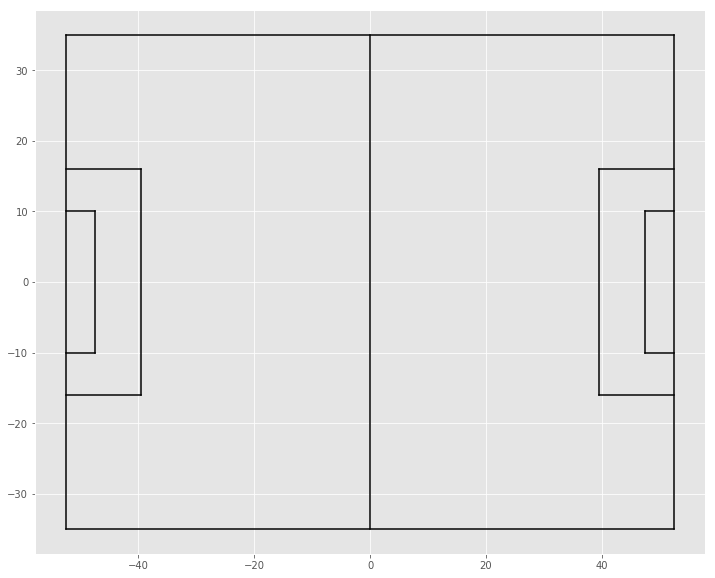

In [218]:
fig = plt.figure()
ax_p = fig.add_subplot(1,1,1)

#Pitch Outline & Centre Line
plt.plot([-52.5,-52.5],[-35,35], color="black")
plt.plot([-52.5,52.5],[35,35], color="black")
plt.plot([52.5,52.5],[35,-35], color="black")
plt.plot([52.5,-52.5],[-35,-35], color="black")
plt.plot([0,0],[-35,35], color="black")
    
    #Left Penalty Area
plt.plot([-39.5,-39.5],[16,-16],color="black")
plt.plot([-52.5,-39.5],[16,16],color="black")
plt.plot([-39.5,-52.5],[-16,-16],color="black")

    #Right Penalty Area
plt.plot([39.5,39.5],[16,-16],color="black")
plt.plot([52.5,39.5],[16,16],color="black")
plt.plot([39.5,52.5],[-16,-16],color="black")
    
    #Left 6-yard Box
plt.plot([-52.5,-47.5],[-10,-10],color="black")
plt.plot([-47.5,-47.5],[-10,10],color="black")
plt.plot([-52.5,-47.5],[10,10],color="black")
    
    #Right 6-yard Box
plt.plot([52.5,47.5],[-10,-10],color="black")
plt.plot([47.5,47.5],[-10,10],color="black")
plt.plot([52.5,47.5],[10,10],color="black")    

plt.show()

In [316]:
df[df['outcome'] == 'Off T'][['type', 'play_pattern', 'team', 'outcome']].groupby('team').get_group('Germany').shape
# df.columns

(23, 4)

In [315]:
df[df['outcome'] == 'Off T'][['type', 'play_pattern', 'team', 'outcome']].groupby('team').get_group('Brazil').shape

(27, 4)

In [314]:
df[df['outcome'] == 'Off T'][['type', 'play_pattern', 'team', 'outcome']].groupby('team').get_group('Belgium').shape

(33, 4)

In [313]:
df[df['outcome'] == 'Off T'][['type', 'play_pattern', 'team', 'outcome']].groupby('team').get_group('France').shape

(32, 4)

In [372]:
shot_belgium.describe()

,shot_distance,start_location_x,start_location_y,end_location_x,end_location_y
count,108.000000,108.000000,108.000000,108.000000,108.000000
mean,14.915479,105.305556,39.805556,116.268519,40.279630
std,9.984136,7.501350,10.731610,6.189540,6.596626
min,1.000000,80.000000,20.000000,94.000000,15.000000
25%,6.307957,100.750000,30.000000,115.000000,36.700000
50%,13.208204,106.500000,40.000000,120.000000,39.800000
75%,22.739780,111.000000,49.000000,120.000000,43.700000
max,51.419841,118.000000,60.000000,120.000000,77.000000


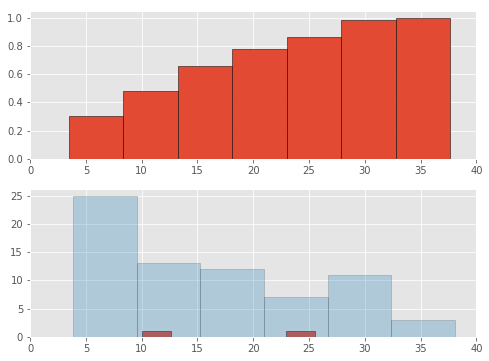

In [421]:
fig = plt.figure(figsize=(8,6))
fig.add_subplot(2,1,1)
plt.hist(shot_germany.shot_distance, bins=7, edgecolor='k', align='right', cumulative=True, density=True)
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40])
fig.add_subplot(2,1,2)
plt.hist(shot_germany[shot_germany.outcome == 'Goal'].shot_distance, bins=6, edgecolor='k', align='right')
plt.hist(shot_germany[shot_germany.outcome != 'Goal'].shot_distance, bins=6, edgecolor='k', align='right', alpha=0.3)
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40])

plt.show()

In [491]:
shot_brazil.shot_distance.describe()

count    103.000000
mean      14.255467
std        9.850262
min        0.000000
25%        6.162278
50%       11.490866
75%       22.683759
max       40.112342
Name: shot_distance, dtype: float64

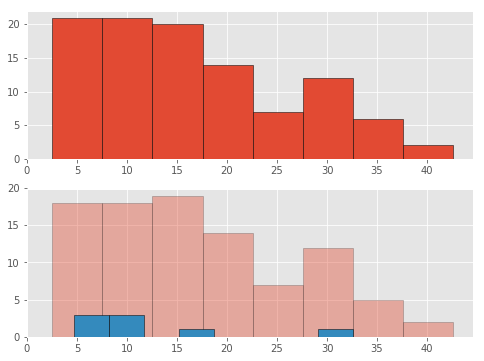

In [493]:
fig = plt.figure(figsize=(8,6))
fig.add_subplot(2,1,1)
plt.hist(shot_brazil.shot_distance, bins=8, edgecolor='k', align='right')
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40])
# fig.add_subplot(2,1,2)
# plt.hist(shot_brazil[shot_brazil.outcome != 'Goal'].shot_distance, bins=8, edgecolor='k', align='right', alpha=0.4)
# plt.hist(shot_brazil[shot_brazil.outcome == 'Goal'].shot_distance, bins=8, edgecolor='k', align='right')
# plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40])

plt.show()

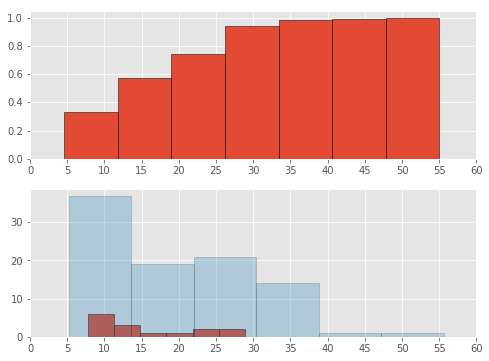

In [424]:
fig = plt.figure(figsize=(8,6))
fig.add_subplot(2,1,1)
plt.hist(shot_belgium.shot_distance, bins=7, edgecolor='k', align='right', cumulative=True, density=True)
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60])
fig.add_subplot(2,1,2)
plt.hist(shot_belgium[shot_belgium.outcome == 'Goal'].shot_distance, bins=6, edgecolor='k', align='right')
plt.hist(shot_belgium[shot_belgium.outcome != 'Goal'].shot_distance, bins=6, edgecolor='k', align='right', alpha=0.3)
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60])

plt.show()

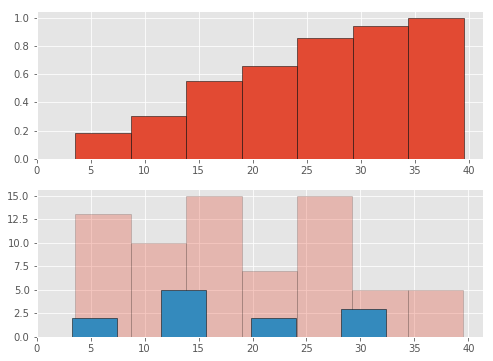

In [417]:
fig = plt.figure(figsize=(8,6))
fig.add_subplot(2,1,1)
plt.hist(shot_fracne.shot_distance, bins=7, edgecolor='k', align='right', density=True, cumulative=True)
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40])
fig.add_subplot(2,1,2)
plt.hist(shot_fracne[shot_fracne.outcome != 'Goal'].shot_distance, bins=7, edgecolor='k', align='right', alpha=0.3)
plt.hist(shot_fracne[shot_fracne.outcome == 'Goal'].shot_distance, bins=7, edgecolor='k', align='right')
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40])

plt.show()

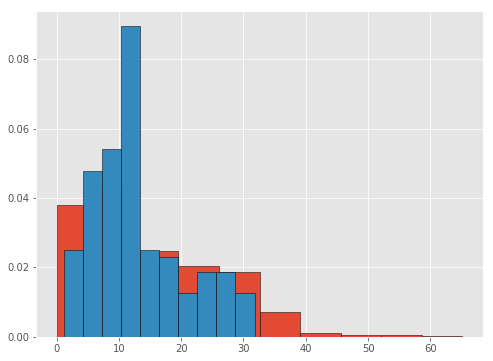

In [432]:
plt.figure(figsize=(8,6))
plt.hist(df[(df['period'] < 5)][['shot_distance', 'outcome']].shot_distance, edgecolor='k', density=True)
plt.hist(df[(df['period'] < 5)][['shot_distance', 'outcome']][df[(df['period'] < 5)][['shot_distance', 'outcome']].outcome == 'Goal'].shot_distance, edgecolor='k', density=True)
plt.show()

In [433]:
df[(df['period'] < 5)][['shot_distance', 'outcome']].describe()

,shot_distance
count,1667.000000
mean,15.076561
std,10.578720
min,0.000000
25%,6.708204
50%,12.369317
75%,23.000870
max,65.145990


In [456]:
shot_germany[shot_germany.outcome == 'Goal'][['play_pattern', 'type']]

,play_pattern,type
10,From Throw In,Open Play
24,From Free Kick,Open Play


In [470]:
shot_germany[shot_germany.outcome != 'Goal'][['play_pattern', 'type']].groupby('play_pattern').count()/shot_germany[shot_germany.outcome != 'Goal'].shape[0]

,type
play_pattern,
From Corner,0.154930
From Counter,0.028169
From Free Kick,0.098592
From Kick Off,0.028169
From Throw In,0.211268
Regular Play,0.478873


In [457]:
shot_belgium[shot_belgium.outcome == 'Goal'][['play_pattern', 'type']]

,play_pattern,type
26,From Corner,Open Play
28,From Corner,Open Play
39,From Keeper,Open Play
1,Other,Penalty
5,Regular Play,Open Play
15,Regular Play,Open Play
19,Regular Play,Open Play
36,From Throw In,Open Play
14,Regular Play,Open Play
12,From Throw In,Open Play


In [463]:
shot_belgium[shot_belgium.outcome != 'Goal'][['play_pattern', 'type']].groupby('play_pattern').count()

,type
play_pattern,
From Corner,17
From Counter,1
From Free Kick,12
From Goal Kick,3
From Keeper,1
From Throw In,7
Regular Play,52


In [508]:
shot_brazil[shot_brazil.outcome == 'Goal'][['play_pattern', 'type']]

,play_pattern,type
17,Regular Play,Open Play
30,Regular Play,Open Play
7,Regular Play,Open Play
15,From Corner,Open Play
24,From Free Kick,Open Play
26,Regular Play,Open Play
3,Regular Play,Open Play
26,Regular Play,Open Play


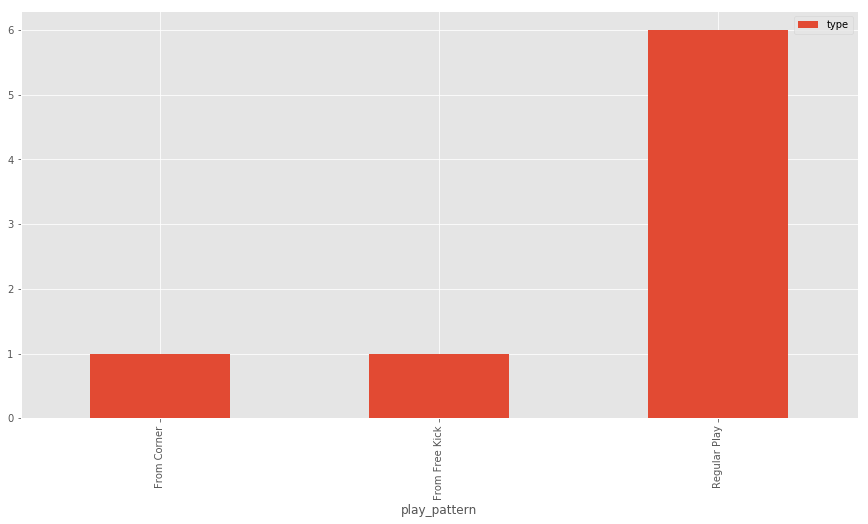

In [512]:
shot_brazil[shot_brazil.outcome == 'Goal'][['play_pattern', 'type']].groupby('play_pattern').count().plot(kind='bar', figsize=(15, 7.5))

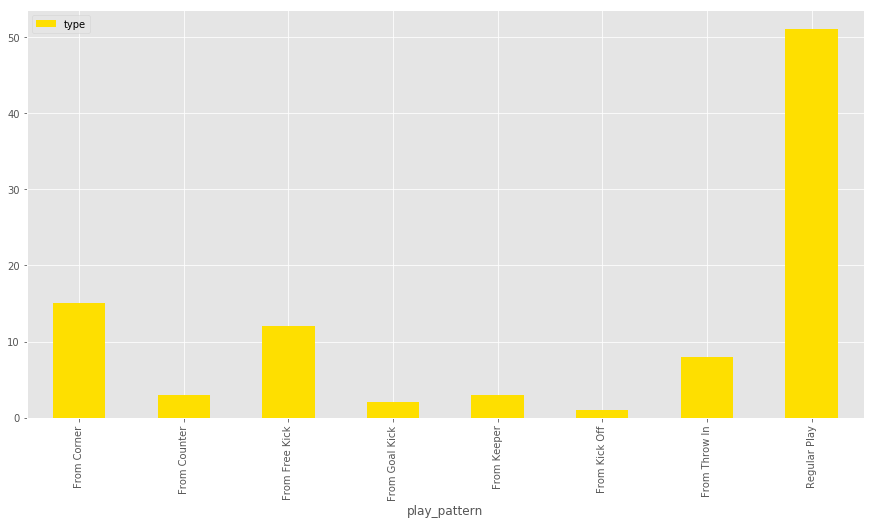

In [530]:
shot_brazil[shot_brazil.outcome != 'Goal'][['play_pattern', 'type']].groupby('play_pattern').count().plot(kind='bar', figsize=(15, 7.5), color='#fedf00')

In [571]:
shot_brazil.play_pattern.unique().tolist()

['Regular Play',
 'From Goal Kick',
 'From Free Kick',
 'From Throw In',
 'From Corner',
 'From Counter',
 'From Kick Off',
 'From Keeper']

<BarContainer object of 8 artists>

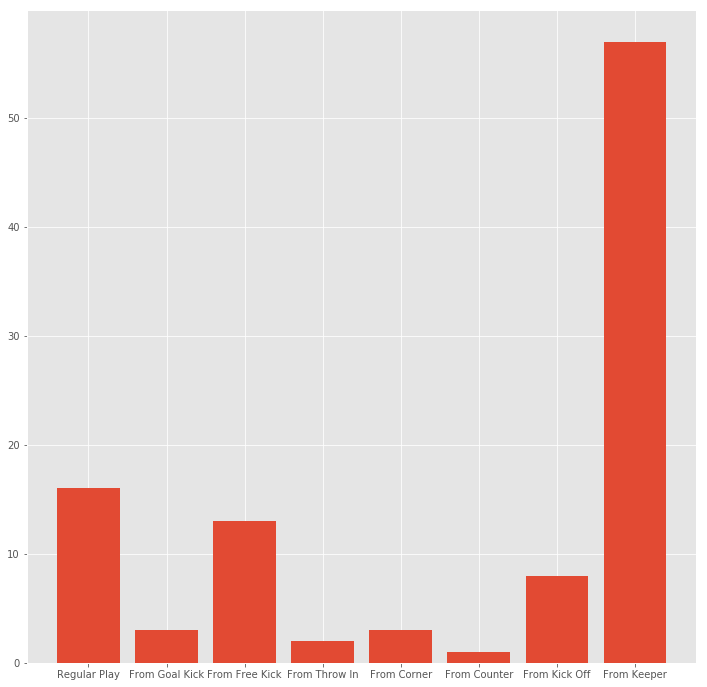

In [572]:
plt.bar(shot_brazil.play_pattern.unique().tolist(),
        shot_brazil[['play_pattern', 'type']].groupby('play_pattern').count().iloc[:,0].tolist())

In [594]:
shot_brazil[shot_brazil.outcome == 'Goal'][['play_pattern', 'type']].groupby('play_pattern').count()

Index(['type'], dtype='object')

In [600]:
sorted(shot_brazil.play_pattern.unique())

['From Corner',
 'From Counter',
 'From Free Kick',
 'From Goal Kick',
 'From Keeper',
 'From Kick Off',
 'From Throw In',
 'Regular Play']

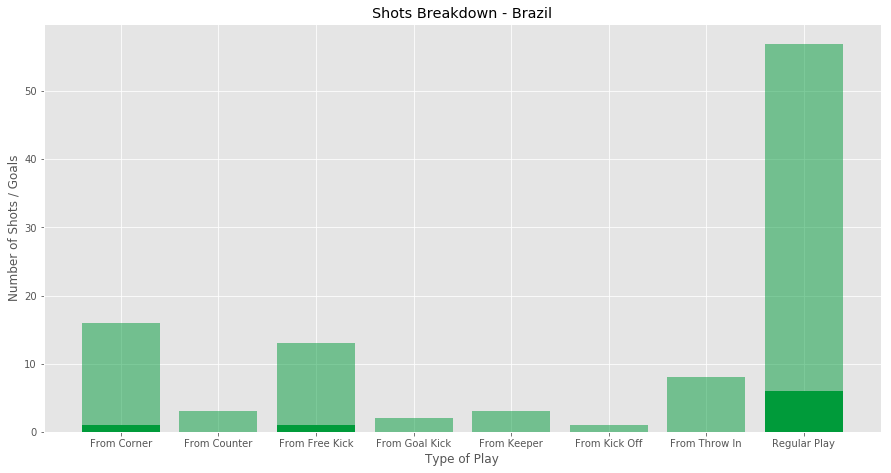

In [624]:
fig = plt.figure(figsize=(15, 7.5))
ax1 = fig.add_subplot(1,1,1)
ax1.bar(sorted(shot_brazil.play_pattern.unique()),
        shot_brazil[['play_pattern', 'type']].groupby('play_pattern').count().iloc[:,0].tolist(),
        color='#009b3a', alpha=0.5)
ax1.bar(sorted(shot_brazil[shot_brazil.outcome == 'Goal']['play_pattern'].unique()),
        shot_brazil[shot_brazil.outcome == 'Goal'][['play_pattern', 'type']].groupby('play_pattern').count().iloc[:, 0].tolist(),
        color='#009b3a')

# ax2 = fig.add_subplot(2,1,2)
# ax2.bar(sorted(shot_brazil[shot_brazil.outcome == 'Goal']['play_pattern'].unique()),
#          shot_brazil[shot_brazil.outcome == 'Goal'][['play_pattern', 'type']].groupby('play_pattern').count().iloc[:, 0].tolist(),
#         color='#009b3a')
# ax2.hist(shot_brazil.shot_distance, bins=8, edgecolor='k', align='right', color='#009b3a')
# plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40])

ax1.set_title('Shots Breakdown - Brazil')
ax1.set_ylabel('Number of Shots / Goals')
ax1.set_xlabel('Type of Play')
# ax2.set_title('Shot Distance Distribution - Brazil')
fig.savefig('pics/shots_brazil.png', format='png',bbox_inches='tight')
plt.show()

In [459]:
shot_fracne[shot_fracne.outcome == 'Goal'][['play_pattern', 'type']]

,play_pattern,type
1,Other,Penalty
8,Regular Play,Open Play
10,Regular Play,Open Play
13,Regular Play,Open Play
8,Other,Penalty
10,Regular Play,Open Play
3,Other,Penalty
14,From Throw In,Open Play
17,Regular Play,Open Play
16,From Corner,Open Play


In [466]:
shot_fracne[shot_fracne.outcome != 'Goal'][['play_pattern', 'type']].groupby('play_pattern').count()

,type
play_pattern,
From Corner,5
From Free Kick,17
From Goal Kick,1
From Keeper,2
From Throw In,7
Regular Play,38


In [486]:
shot_outcome.describe()

outcome,Blocked,Goal,Off T,Post,Saved,Wayward,match_played,total_shot,goal_conversion,shot_per_game,goal_per_game,conversion_per_game
count,32.000000,32.000000,32.000000,32.00000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,14.343750,4.906250,17.843750,0.71875,10.312500,3.968750,4.000000,41.750000,0.107947,10.212946,1.098289,0.027131
std,7.896955,3.813045,8.736683,0.92403,5.772222,2.494955,1.344043,19.488624,0.049517,2.210220,0.519533,0.010315
min,3.000000,1.000000,9.000000,0.00000,3.000000,0.000000,3.000000,22.000000,0.040000,7.333333,0.333333,0.013333
25%,8.000000,2.000000,12.000000,0.00000,7.000000,2.750000,3.000000,28.000000,0.066667,8.458333,0.666667,0.020487
50%,13.000000,3.000000,15.000000,0.50000,8.500000,3.500000,3.500000,34.000000,0.103006,9.775000,1.000000,0.023905
75%,20.000000,6.000000,21.000000,1.00000,13.250000,5.000000,4.250000,49.250000,0.143857,11.000000,1.500000,0.034189
max,30.000000,15.000000,47.000000,4.00000,31.000000,10.000000,7.000000,92.000000,0.243902,16.666667,2.142857,0.050505
